In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper

import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import torchmetrics
import timm
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size=4
image_count=50
img_size=256
tf = ToTensor()


In [2]:

train_image_Oropharynx_path='../../data/image_data_pd/**/Oropharynx/*'
train_image_Tonguebase_path='../../data/image_data_pd/**/Tonguebase/*'
train_image_Epiglottis_path='../../data/image_data_pd/**/Epiglottis/*'

test_image_Oropharynx_path='../../data/image_data_pd_test/**/Oropharynx/*'
test_image_Tonguebase_path='../../data/image_data_pd_test/**/Tonguebase/*'
test_image_Epiglottis_path='../../data/image_data_pd_test/**/Epiglottis/*'
# class CustomDataset(Dataset):
#     def __init__(self, image_list, label_list):
#         self.img_path = image_list

#         self.label = label_list


#     def __len__(self):
#         return len(self.label)

#     def __getitem__(self, idx):
#         image_tensor = torch.empty((image_count,3, img_size, img_size))
        
#         image_file_list = glob(self.img_path[idx]+'/*.jpg')
#         if len(image_file_list)>image_count:
#             image_index = torch.randint(low=0, high=len(
#                 image_file_list)-image_count, size=(1,))
#             count = 0
#             for index in range(image_index[0],image_index[0]+image_count):
#                 image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
#                 image_tensor[count] = image
#                 count += 1
#         else:
#             count = 0
#             for index in range(len(image_file_list)):
#                 image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
#                 image_tensor[count] = image
#                 count += 1
#             for i in range(image_count-count):
#                 image = 1-tf(Image.open(image_file_list[i]).resize((img_size,img_size)))
#                 image_tensor[count] = image
#                 count += 1
#         label_tensor =  self.label[idx]
#         return image_tensor, label_tensor
    
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list

        self.label = label_list


    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        image_tensor = self.img_path[idx]
    
        label_tensor =  self.label[idx]
        return image_tensor, label_tensor

train_image_list = []
train_label_list = []
image_Oropharynx_list = glob(train_image_Oropharynx_path)
image_Oropharynx_label = torch.zeros(len(image_Oropharynx_list), 1)
image_Tonguebase_list = glob(train_image_Tonguebase_path)
image_Tonguebase_label = torch.ones(len(image_Tonguebase_list), 1)
image_Epiglottis_list = glob(train_image_Epiglottis_path)
image_Epiglottis_label = torch.ones(len(image_Epiglottis_list), 1)*2


train_image_list.extend(image_Oropharynx_list)
train_image_list.extend(image_Tonguebase_list)
train_image_list.extend(image_Epiglottis_list)
train_label_list.extend(image_Oropharynx_label)
train_label_list.extend(image_Tonguebase_label)
train_label_list.extend(image_Epiglottis_label)

train_image_tensor = torch.empty((len(train_image_list),image_count,3, img_size, img_size))
for i in tqdm(range(len(train_image_list))):   
    image_file_list = glob(train_image_list[i]+'/*.jpg')
    if len(image_file_list)>image_count:
        image_index = torch.randint(low=0, high=len(
            image_file_list)-image_count, size=(1,))
        count = 0
        for index in range(image_count):
            image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
            train_image_tensor[i,count] = image
            count += 1
    else:
        count = 0
        for index in range(0,len(image_file_list)):
            image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
            train_image_tensor[i,count] = image
            count += 1
        for j in range(image_count-count):
            image = 1-tf(Image.open(image_file_list[j]).resize((img_size,img_size)))
            train_image_tensor[i,count] = image
            count += 1

test_image_list = []
test_label_list = []
image_Oropharynx_list = glob(test_image_Oropharynx_path)
image_Oropharynx_label = torch.zeros(len(image_Oropharynx_list), 1)
image_Tonguebase_list = glob(test_image_Tonguebase_path)
image_Tonguebase_label = torch.ones(len(image_Tonguebase_list), 1)
image_Epiglottis_list = glob(test_image_Epiglottis_path)
image_Epiglottis_label = torch.ones(len(image_Epiglottis_list), 1)*2


test_image_list.extend(image_Oropharynx_list)
test_image_list.extend(image_Tonguebase_list)
test_image_list.extend(image_Epiglottis_list)
test_label_list.extend(image_Oropharynx_label)
test_label_list.extend(image_Tonguebase_label)
test_label_list.extend(image_Epiglottis_label)

test_image_tensor = torch.empty((len(test_image_list),image_count,3, img_size, img_size))
for i in tqdm(range(len(test_image_list))):   
    image_file_list = glob(test_image_list[i]+'/*.jpg')
    if len(image_file_list)>image_count:
        image_index = torch.randint(low=0, high=len(
            image_file_list)-image_count, size=(1,))
        count = 0
        for index in range(image_count):
            image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
            test_image_tensor[i,count] = image
            count += 1
    else:
        count = 0
        for index in range(len(image_file_list)):
            image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
            test_image_tensor[i,count] = image
            count += 1
        for j in range(image_count-count):
            image = 1-tf(Image.open(image_file_list[j]).resize((img_size,img_size)))
            test_image_tensor[i,count] = image
            count += 1
            
train_dataset = CustomDataset(train_image_tensor, F.one_hot(torch.tensor(train_label_list).to(torch.int64)))

test_dataset = CustomDataset(test_image_tensor, F.one_hot(torch.tensor(test_label_list).to(torch.int64)))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 599/599 [04:10<00:00,  2.39it/s]


In [3]:
class FeatureExtractor(nn.Module):
    """Feature extoractor block"""
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        cnn1= timm.create_model('efficientnet_b2', pretrained=True)
        self.feature_ex = nn.Sequential(*list(cnn1.children())[:-1])

    def forward(self, inputs):
        features = self.feature_ex(inputs)
        
        return features
    
class AttentionMILModel(nn.Module):
    def __init__(self, num_classes, image_feature_dim,feature_extractor_scale1: FeatureExtractor):
        super(AttentionMILModel, self).__init__()
        self.num_classes = num_classes
        self.image_feature_dim = image_feature_dim

        # Remove the classification head of the CNN model
        self.feature_extractor = feature_extractor_scale1
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(image_feature_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Classification layer
        self.classification_layer = nn.Linear(image_feature_dim, num_classes)
        self.dropout=torch.nn.Dropout(0.2)
    def forward(self, inputs):
        batch_size, num_tiles, channels, height, width = inputs.size()
        
        # Flatten the inputs
        inputs = inputs.view(-1, channels, height, width)
        
        # Feature extraction using the pre-trained CNN
        features = self.feature_extractor(inputs)  # Shape: (batch_size * num_tiles, 2048, 1, 1)
        
        # Reshape features
        features = features.view(batch_size, num_tiles, -1)  # Shape: (batch_size, num_tiles, 2048)
        
        # Attention mechanism
        attention_weights = self.attention(features)  # Shape: (batch_size, num_tiles, 1)
        attention_weights = F.softmax(attention_weights, dim=1)  # Normalize attention weights
        
        # Apply attention weights to features
        attended_features = torch.sum(features * attention_weights, dim=1)  # Shape: (batch_size, 2048)
        attended_features=self.dropout(attended_features)
        attended_features=F.relu(attended_features)
        # Classification layer
        logits = self.classification_layer(attended_features)  # Shape: (batch_size, num_classes)
        
        return logits
Feature_Extractor=FeatureExtractor()
model = AttentionMILModel(3,1408,Feature_Extractor)
model = model.to(device)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
summary(model,(batch_size,image_count,3,img_size,img_size))

Layer (type:depth-idx)                                  Output Shape              Param #
AttentionMILModel                                       [4, 3]                    --
├─FeatureExtractor: 1-1                                 [200, 1408]               --
│    └─Sequential: 2-1                                  [200, 1408]               --
│    │    └─Conv2d: 3-1                                 [200, 32, 128, 128]       864
│    │    └─BatchNormAct2d: 3-2                         [200, 32, 128, 128]       64
│    │    └─Sequential: 3-3                             [200, 352, 8, 8]          7,201,634
│    │    └─Conv2d: 3-4                                 [200, 1408, 8, 8]         495,616
│    │    └─BatchNormAct2d: 3-5                         [200, 1408, 8, 8]         2,816
│    │    └─SelectAdaptivePool2d: 3-6                   [200, 1408]               --
├─Sequential: 1-2                                       [4, 50, 1]                --
│    └─Linear: 2-2                          

epoch: 1/50 Step: 604 loss : 0.6602 accuracy: 0.4776: 100%|██████████| 603/603 [04:21<00:00,  2.31it/s]
Validation epoch: 1/50 Step: 150 loss : 0.6331  accuracy: 0.5403: 100%|██████████| 149/149 [00:20<00:00,  7.35it/s]
epoch: 2/50 Step: 604 loss : 0.6270 accuracy: 0.5419: 100%|██████████| 603/603 [04:22<00:00,  2.30it/s]
Validation epoch: 2/50 Step: 150 loss : 0.6301  accuracy: 0.5369: 100%|██████████| 149/149 [00:20<00:00,  7.20it/s]
epoch: 3/50 Step: 604 loss : 0.6072 accuracy: 0.5842: 100%|██████████| 603/603 [04:22<00:00,  2.30it/s]
Validation epoch: 3/50 Step: 150 loss : 0.6216  accuracy: 0.5554: 100%|██████████| 149/149 [00:20<00:00,  7.11it/s]
epoch: 4/50 Step: 604 loss : 0.5871 accuracy: 0.6119: 100%|██████████| 603/603 [04:22<00:00,  2.30it/s]
Validation epoch: 4/50 Step: 150 loss : 0.6307  accuracy: 0.5235: 100%|██████████| 149/149 [00:21<00:00,  7.08it/s]
epoch: 5/50 Step: 604 loss : 0.5506 accuracy: 0.6833: 100%|██████████| 603/603 [04:23<00:00,  2.29it/s]
Validation epoch

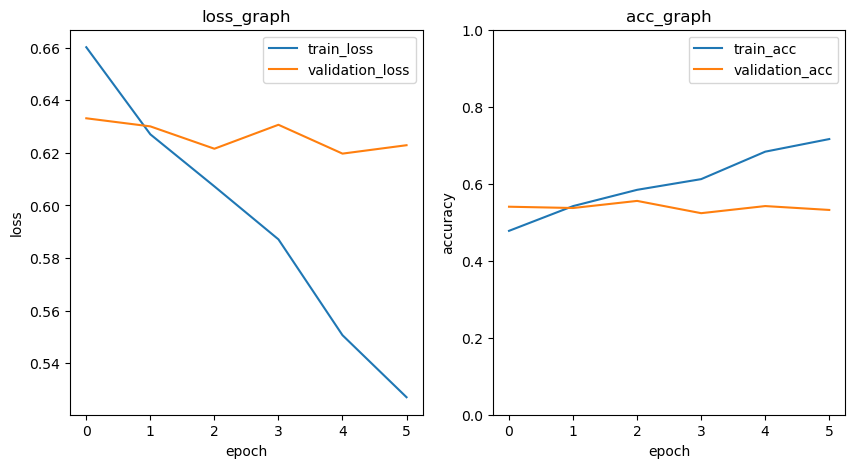

epoch: 7/50 Step: 604 loss : 0.5031 accuracy: 0.7624: 100%|██████████| 603/603 [04:23<00:00,  2.28it/s]
Validation epoch: 7/50 Step: 150 loss : 0.6301  accuracy: 0.5218: 100%|██████████| 149/149 [00:21<00:00,  7.01it/s]
epoch: 8/50 Step: 604 loss : 0.4885 accuracy: 0.7803: 100%|██████████| 603/603 [04:25<00:00,  2.27it/s]
Validation epoch: 8/50 Step: 150 loss : 0.6385  accuracy: 0.4799: 100%|██████████| 149/149 [00:21<00:00,  6.95it/s]
epoch: 9/50 Step: 604 loss : 0.4701 accuracy: 0.8172: 100%|██████████| 603/603 [04:25<00:00,  2.28it/s]
Validation epoch: 9/50 Step: 150 loss : 0.6285  accuracy: 0.5201: 100%|██████████| 149/149 [00:21<00:00,  7.01it/s]
epoch: 10/50 Step: 604 loss : 0.4600 accuracy: 0.8259: 100%|██████████| 603/603 [04:24<00:00,  2.28it/s]
Validation epoch: 10/50 Step: 150 loss : 0.6340  accuracy: 0.5000: 100%|██████████| 149/149 [00:21<00:00,  6.98it/s]
epoch: 11/50 Step: 604 loss : 0.4456 accuracy: 0.8512: 100%|██████████| 603/603 [04:23<00:00,  2.29it/s]
Validation ep

KeyboardInterrupt: 

In [4]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
sig=nn.Sigmoid()
val_acc_list=[]
MIN_acc=0
numSample_list = [len(image_Oropharynx_list),len(image_Tonguebase_list),len(image_Epiglottis_list)]
weights = torch.Tensor([1 - (x / sum(numSample_list)) for x in numSample_list]).to(device)
for epoch in range(50):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    model.train()
    for x, y in train:
        
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = F.cross_entropy(predict.softmax(dim=1), y,weight=weights) # cost 구함
        acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        train.set_description(f"epoch: {epoch+1}/{50} Step: {count+1} loss : {running_loss/count:.4f} accuracy: {acc_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count).cpu().detach().numpy())
#validation
    val=tqdm(validation_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            predict = model(x).to(device)
            cost = F.cross_entropy(predict.softmax(dim=1), y,weight=weights) # cost 구함
            acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
            val_running_loss+=cost.item()
            acc_loss+=acc
            val.set_description(f"Validation epoch: {epoch+1}/{50} Step: {count+1} loss : {val_running_loss/count:.4f}  accuracy: {acc_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count).cpu().detach().numpy())
    if epoch%20==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
        
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/attention_MIL_1_eff50_callback.pt')
        MIN_loss=(val_running_loss/count)
        
    if MIN_acc<(acc_loss/count):
        torch.save(model.state_dict(), '../../model/attention_MIL_1_eff50_acc_callback.pt')
        MIN_acc=(acc_loss/count)
        
torch.save(model.state_dict(), '../../model/attention_1_eff50_MIL.pt')